In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

# 1. (60%) Stepwise Regression and Regularization- Ridge, Lasso, and Elastic Net

## Load data and preprocessing

In [2]:
fp_df = pd.read_csv('MiningProcess_Flotation_Plant_Database.csv', parse_dates=['date'], decimal=',')

In [3]:
fp_df

,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,2017-03-10 01:00:00,55.20,16.98,3019.53,557.434,395.713,10.06640,1.74000,249.214,253.235,...,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31
1,2017-03-10 01:00:00,55.20,16.98,3024.41,563.965,397.383,10.06720,1.74000,249.719,250.532,...,248.994,451.891,429.560,432.939,448.086,496.363,445.922,498.075,66.91,1.31
2,2017-03-10 01:00:00,55.20,16.98,3043.46,568.054,399.668,10.06800,1.74000,249.741,247.874,...,248.071,451.240,468.927,434.610,449.688,484.411,447.826,458.567,66.91,1.31
3,2017-03-10 01:00:00,55.20,16.98,3047.36,568.665,397.939,10.06890,1.74000,249.917,254.487,...,251.147,452.441,458.165,442.865,446.210,471.411,437.690,427.669,66.91,1.31
4,2017-03-10 01:00:00,55.20,16.98,3033.69,558.167,400.254,10.06970,1.74000,250.203,252.136,...,248.928,452.441,452.900,450.523,453.670,462.598,443.682,425.679,66.91,1.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737448,2017-09-09 23:00:00,49.75,23.20,2710.94,441.052,386.570,9.62129,1.65365,302.344,298.786,...,313.695,392.160,430.702,872.008,418.725,497.548,446.357,416.892,64.27,1.71
737449,2017-09-09 23:00:00,49.75,23.20,2692.01,473.436,384.939,9.62063,1.65352,303.013,301.879,...,236.700,401.505,404.616,864.409,418.377,506.398,372.995,426.337,64.27,1.71
737450,2017-09-09 23:00:00,49.75,23.20,2692.20,500.488,383.496,9.61874,1.65338,303.662,307.397,...,225.879,408.899,399.316,867.598,419.531,503.414,336.035,433.130,64.27,1.71
737451,2017-09-09 23:00:00,49.75,23.20,1164.12,491.548,384.976,9.61686,1.65324,302.550,301.959,...,308.115,405.107,466.832,876.591,407.299,502.301,340.844,433.966,64.27,1.71


### 檢查欄位資料型態

In [4]:
fp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737453 entries, 0 to 737452
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   date                          737453 non-null  datetime64[ns]
 1   % Iron Feed                   737453 non-null  float64       
 2   % Silica Feed                 737453 non-null  float64       
 3   Starch Flow                   737453 non-null  float64       
 4   Amina Flow                    737453 non-null  float64       
 5   Ore Pulp Flow                 737453 non-null  float64       
 6   Ore Pulp pH                   737453 non-null  float64       
 7   Ore Pulp Density              737453 non-null  float64       
 8   Flotation Column 01 Air Flow  737453 non-null  float64       
 9   Flotation Column 02 Air Flow  737453 non-null  float64       
 10  Flotation Column 03 Air Flow  737453 non-null  float64       
 11  Flotation Col

除了 date 欄位為 datetime 型態，其他都是 float 型態。

由於要建立的模型並非時間序列模型，因此訓練模型時不考慮 date 欄位。

### Resample data to hourly basis
因為有些欄位是每 20s sample 一次，其他欄位是 1 小時 sample 一次，因此統一將所有欄位為 1 小時 sample 一次，取當前小時的第一筆資料。

此外由於 resample 成小時為單位，因此需要 drop 掉空值的資料。

In [5]:
fp_df = fp_df.set_index('date').resample('H').first().dropna()
fp_df

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
date,,,,,,,,,,,,,,,,,,,,,
2017-03-10 01:00:00,55.20,16.98,3019.530,557.434,395.713000,10.06640,1.74000,249.214,253.235,250.576,...,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31
2017-03-10 02:00:00,55.20,16.98,3170.410,539.673,399.697000,10.15890,1.66910,249.291,248.269,248.313,...,249.774,462.601,488.724,441.674,433.629,448.477,480.866,489.382,67.06,1.11
2017-03-10 03:00:00,55.20,16.98,3365.650,573.517,399.023000,10.08600,1.70565,249.379,253.312,252.092,...,249.060,456.445,440.432,456.625,432.736,464.334,445.950,432.906,66.97,1.27
2017-03-10 04:00:00,55.20,16.98,2693.750,592.133,409.204000,9.94880,1.72472,248.302,251.906,251.115,...,249.236,459.248,480.114,453.814,433.885,438.642,421.974,408.193,66.75,1.36
2017-03-10 05:00:00,55.20,16.98,2352.216,601.807,398.145000,9.84375,1.75928,248.950,246.313,248.071,...,252.686,558.545,548.280,551.960,561.720,543.070,529.260,514.240,66.63,1.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-09 19:00:00,49.75,23.20,2888.060,494.990,376.468000,9.27990,1.66786,317.065,297.754,301.685,...,302.330,577.943,489.959,504.995,440.587,481.295,434.701,401.796,65.05,1.65
2017-09-09 20:00:00,49.75,23.20,4218.570,492.027,378.630000,9.15799,1.64888,302.081,301.348,300.543,...,342.615,412.491,510.388,342.202,371.883,594.518,443.687,375.044,64.83,1.71
2017-09-09 21:00:00,49.75,23.20,3159.100,520.986,381.468667,9.58069,1.73620,296.063,298.480,299.085,...,332.393,401.456,533.409,390.060,395.463,587.855,489.406,504.982,64.29,1.80


儲存挑選出的重要變數

In [6]:
select_features = {}

### 視覺化各變數檢視分布狀況

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe03c151940>,
      dtype=object)

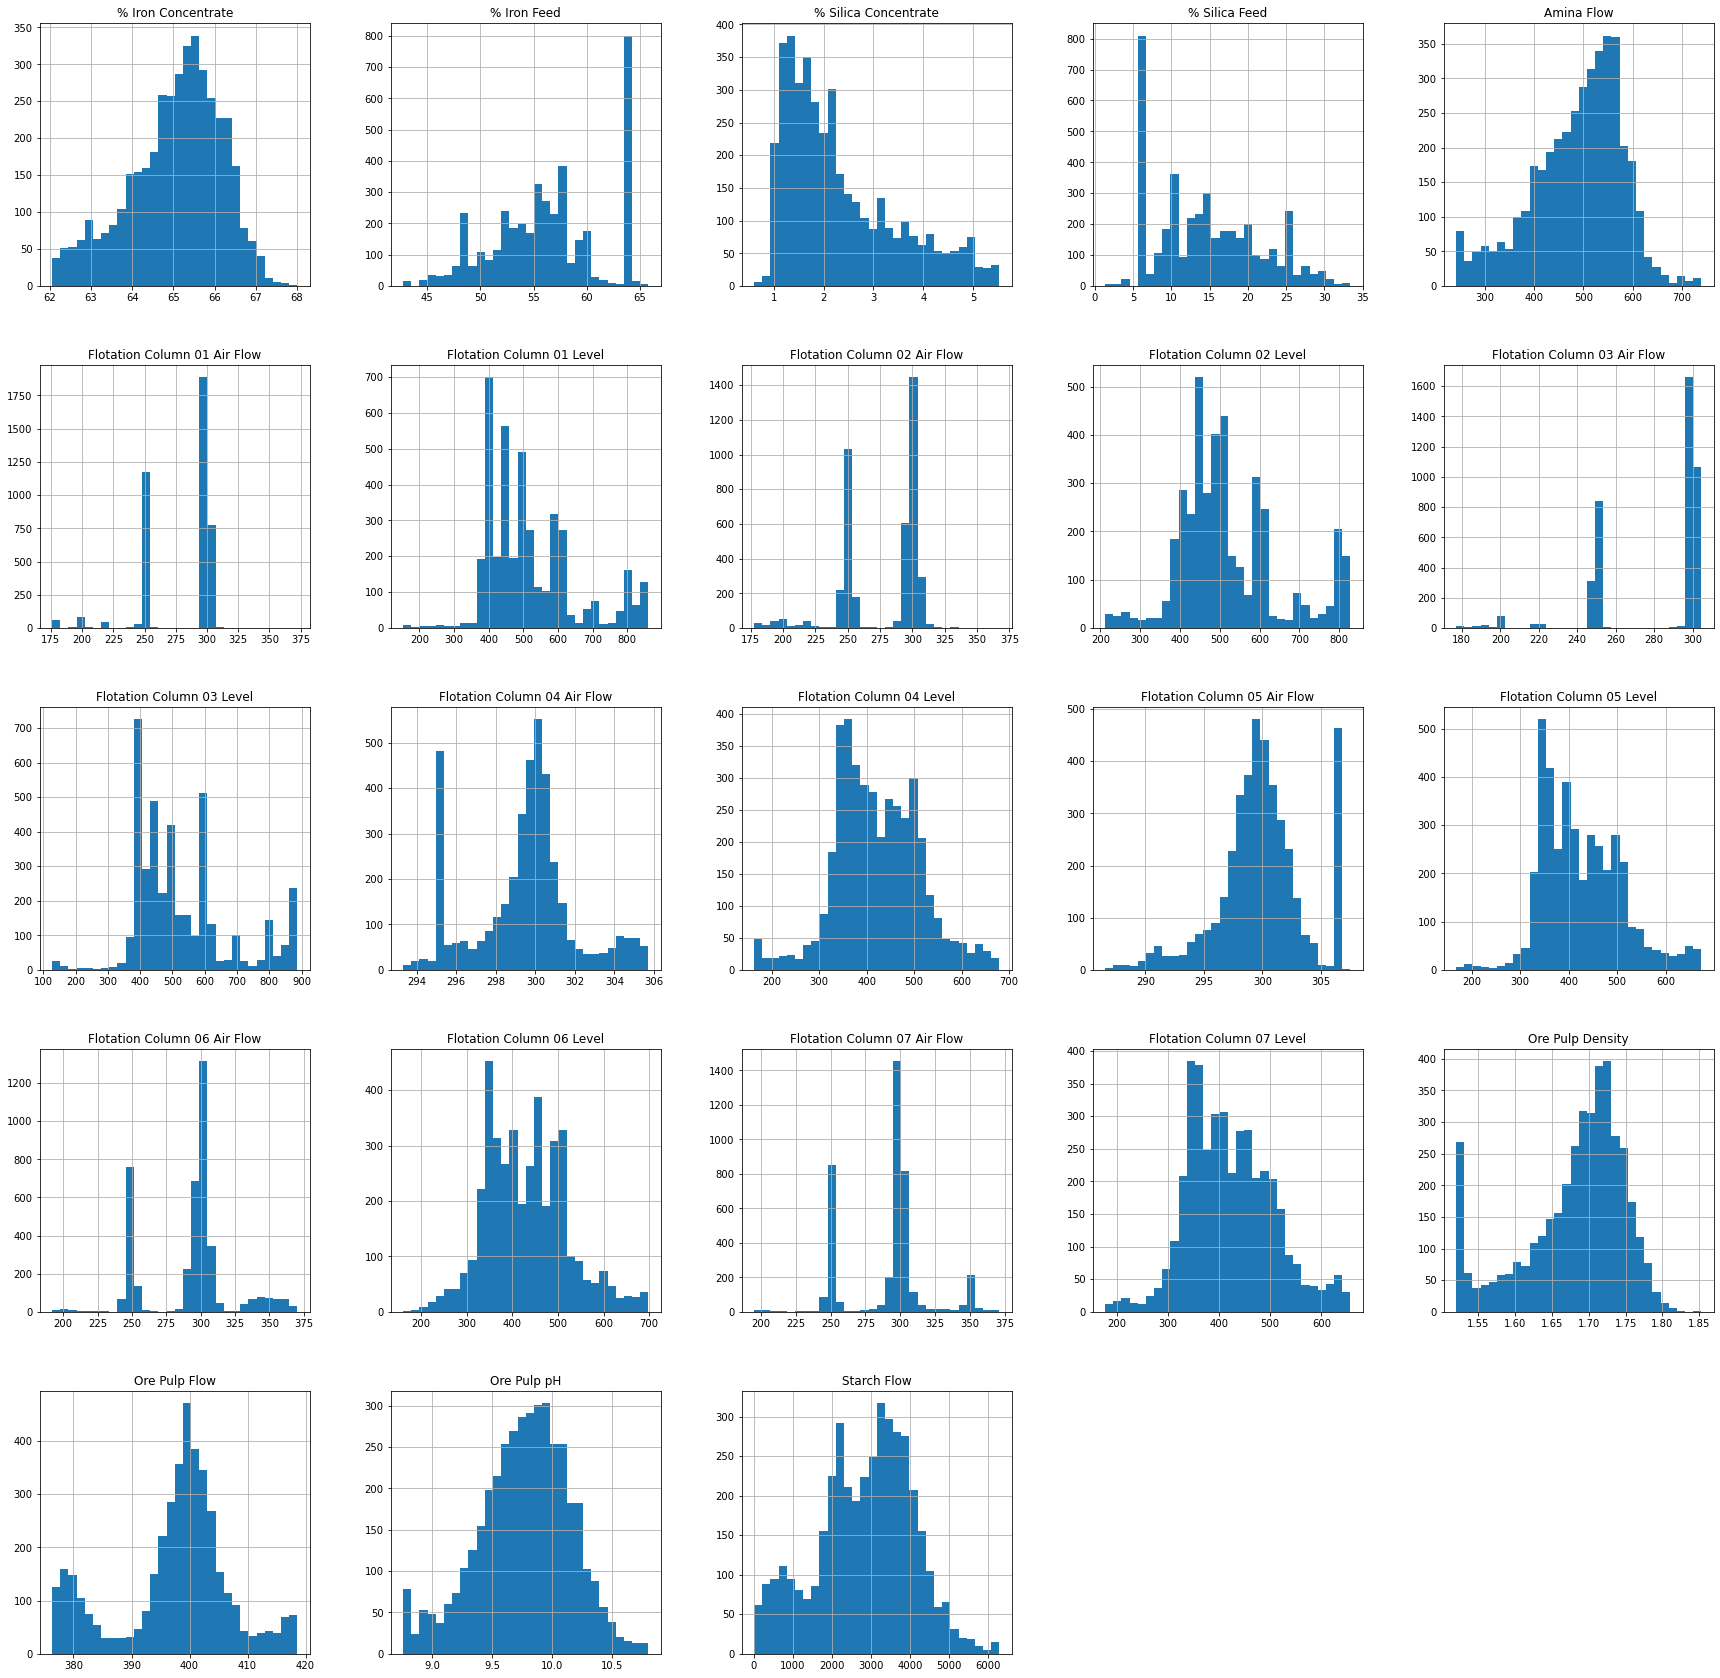

In [7]:
fp_df.hist(bins=30, figsize=(30, 30))

---
## (a) (5%) Identify the important variable by linear regression with ordinary least squares (OLS) (i.e. ranked by p-value).
根據題目指示，放入除了 % Silica Concentrate 與 % Iron Concentrate 外的所有變數作為自變數，並設 % Silica Concentrate 為應變數。

由於此模型是用來找出對 Silica Concentrate 重要變數，並非是預測為目的，所以在此並未將資料集切分成訓練資料與測試資料。

In [8]:
import statsmodels.api as sm

In [9]:
X = fp_df.drop(columns=['% Silica Concentrate', '% Iron Concentrate'])
y = fp_df['% Silica Concentrate']
X = sm.add_constant(X)
model = sm.OLS(y, X)
ols_result = model.fit()
print(ols_result.summary())

                             OLS Regression Results                             
Dep. Variable:     % Silica Concentrate   R-squared:                       0.149
Model:                              OLS   Adj. R-squared:                  0.145
Method:                   Least Squares   F-statistic:                     33.99
Date:                  Fri, 12 Nov 2021   Prob (F-statistic):          5.39e-126
Time:                          14:19:48   Log-Likelihood:                -5985.7
No. Observations:                  4097   AIC:                         1.202e+04
Df Residuals:                      4075   BIC:                         1.215e+04
Df Model:                            21                                         
Covariance Type:              nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

找出模型中所有 p-value $\leq$ 0.05 的變數，視為 important variables，因為至少有 95% 的信心水準相信此變數對 % Silica Concentrate 的變異影響具顯著性。

將重要變數記錄在 select_features 與 select_features_df（存在 dataframe 中比較方便檢視哪些變數被哪些方法選到）中。

In [10]:
select_features['OLS'] = X.columns[ols_result.pvalues <= 0.05]
select_features_df = pd.DataFrame(columns = X.columns)    # column 為 自變數們，index 為挑選自變數的方法，row 為此變數是否有被選到
select_features_df.loc['OLS'] = np.nan

for col in select_features['OLS']:
    select_features_df[col]['OLS'] = 1
    
select_features['OLS']

Index(['Starch Flow', 'Amina Flow', 'Ore Pulp Flow', 'Ore Pulp pH',
       'Ore Pulp Density', 'Flotation Column 01 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
       'Flotation Column 05 Level', 'Flotation Column 07 Level'],
      dtype='object')

除此之外也可以進一步將變數進行排序，若按照在統計上判斷此變數對 % Silica Concentrate 的影響顯著性，可以將自變數按照 p-value 由小到大，或是 t value 取絕對值由大到小排序。以下列出 p-value 由小到大排序變數的結果。

In [11]:
ols_result.pvalues.sort_values()

Amina Flow                      6.039125e-32
Ore Pulp pH                     2.229138e-12
Ore Pulp Density                1.491946e-08
Flotation Column 01 Air Flow    2.253392e-06
Flotation Column 04 Air Flow    1.365226e-05
Flotation Column 05 Level       2.788970e-04
Ore Pulp Flow                   2.304115e-03
Flotation Column 07 Level       9.535139e-03
Flotation Column 03 Air Flow    1.374436e-02
Starch Flow                     1.852830e-02
Flotation Column 06 Air Flow    1.161082e-01
Flotation Column 03 Level       2.404013e-01
Flotation Column 06 Level       2.459638e-01
const                           2.750051e-01
Flotation Column 07 Air Flow    3.229933e-01
Flotation Column 02 Air Flow    3.326581e-01
Flotation Column 01 Level       3.485281e-01
% Silica Feed                   4.244508e-01
Flotation Column 05 Air Flow    4.505214e-01
Flotation Column 02 Level       7.645696e-01
% Iron Feed                     8.304948e-01
Flotation Column 04 Level       8.795649e-01
dtype: flo

---
## (b) (5%) Identify the important variable by stepwise regression. (hint: you can select forward selection, backward elimination, or both)

In [12]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LinearRegression
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

參考助教的課程內容，使用 mlxtend.feature_selection 中的 SequentialFeatureSelector 分別嘗試 Backward 與 Forward stepwise regression
### Backward Stepwise Regression

In [13]:
clf = LinearRegression()

sfs1 = sfs(clf, k_features = 1, forward=False, floating=False, scoring='r2', cv=10)
sfs1 = sfs1.fit(X, y)

In [14]:
sfs1.get_metric_dict()

{22: {'feature_idx': (0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21),
  'cv_scores': array([-0.260086  , -0.05784175, -0.04257323,  0.23906922,  0.10136506,
         -0.10708669, -0.14474092, -0.03743709, -0.03727387,  0.02358908]),
  'avg_score': -0.032301617751316125,
  'feature_names': ('const',
   '% Iron Feed',
   '% Silica Feed',
   'Starch Flow',
   'Amina Flow',
   'Ore Pulp Flow',
   'Ore Pulp pH',
   'Ore Pulp Density',
   'Flotation Column 01 Air Flow',
   'Flotation Column 02 Air Flow',
   'Flotation Column 03 Air Flow',
   'Flotation Column 04 Air Flow',
   'Flotation Column 05 Air Flow',
   'Flotation Column 06 Air Flow',
   'Flotation Column 07 Air Flow',
   'Flotation Column 01 Level',
   'Flotation Column 02 Level',
   'Flotation Column 03 Level',
   'Flotation Column 04 Level',
   'Flotation Column 05 Level',
   'Flotation Column 06 Level',
   'Flotation Column 07 Level'),
  

In [15]:
backward_feature_df = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T.sort_values(by="avg_score",ascending=False).drop(["cv_scores"],axis=1)
backward_feature_df

,feature_idx,avg_score,feature_names,ci_bound,std_dev,std_err
11,"(0, 2, 3, 4, 6, 7, 8, 12, 13, 19, 21)",0.013362,"(const, % Silica Feed, Starch Flow, Amina Flow...",0.0985461,0.132684,0.044228
10,"(2, 3, 4, 6, 7, 8, 12, 13, 19, 21)",0.013362,"(% Silica Feed, Starch Flow, Amina Flow, Ore P...",0.0985461,0.132684,0.044228
12,"(0, 2, 3, 4, 6, 7, 8, 12, 13, 19, 20, 21)",0.012536,"(const, % Silica Feed, Starch Flow, Amina Flow...",0.0987468,0.132954,0.0443181
9,"(2, 3, 4, 6, 7, 8, 12, 13, 19)",0.0124741,"(% Silica Feed, Starch Flow, Amina Flow, Ore P...",0.0962752,0.129626,0.0432088
13,"(0, 2, 3, 4, 6, 7, 8, 9, 12, 13, 19, 20, 21)",0.0116451,"(const, % Silica Feed, Starch Flow, Amina Flow...",0.0986218,0.132786,0.044262
8,"(2, 4, 6, 7, 8, 12, 13, 19)",0.0111977,"(% Silica Feed, Amina Flow, Ore Pulp pH, Ore P...",0.0954065,0.128457,0.0428189
14,"(0, 2, 3, 4, 6, 7, 8, 9, 12, 13, 18, 19, 20, 21)",0.0106762,"(const, % Silica Feed, Starch Flow, Amina Flow...",0.0987002,0.132891,0.0442971
7,"(2, 4, 6, 7, 8, 13, 19)",0.0100806,"(% Silica Feed, Amina Flow, Ore Pulp pH, Ore P...",0.0961848,0.129505,0.0431682
15,"(0, 2, 3, 4, 6, 7, 8, 9, 12, 13, 15, 18, 19, 2...",0.00704341,"(const, % Silica Feed, Starch Flow, Amina Flow...",0.101779,0.137037,0.045679
16,"(0, 2, 3, 4, 6, 7, 8, 9, 12, 13, 15, 17, 18, 1...",0.0057443,"(const, % Silica Feed, Starch Flow, Amina Flow...",0.103763,0.139708,0.0465692


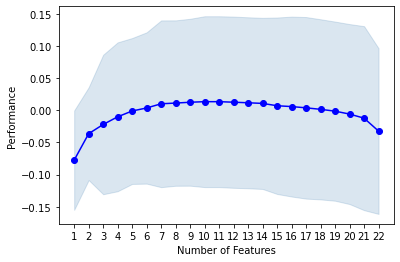

In [16]:
fig = plot_sfs(sfs1.get_metric_dict())

選 Average $R^2$ 最高的變數組合作為 backward stepwise regression 的結果

In [17]:
select_features['Backward Stepwise Regression'] = backward_feature_df.reset_index()['feature_names'][0]
select_features_df.loc['Backward Stepwise Regression'] = np.nan

for col in select_features['Backward Stepwise Regression']:
    select_features_df[col]['Backward Stepwise Regression'] = 1

select_features['Backward Stepwise Regression']

('const',
 '% Silica Feed',
 'Starch Flow',
 'Amina Flow',
 'Ore Pulp pH',
 'Ore Pulp Density',
 'Flotation Column 01 Air Flow',
 'Flotation Column 05 Air Flow',
 'Flotation Column 06 Air Flow',
 'Flotation Column 05 Level',
 'Flotation Column 07 Level')

### Forward Stepwise Regression

In [18]:
clf = LinearRegression()

# Build backward feature selection
sfs2 = sfs(clf, k_features = len(X.columns.tolist()), forward=True, floating=False, scoring='r2', cv=10)
# Perform SFFS
sfs2 = sfs2.fit(X, y)

In [19]:
sfs2.get_metric_dict()

{1: {'feature_idx': (8,),
  'cv_scores': array([-0.04071217, -0.07831138, -0.13844983,  0.09373869, -0.12507761,
         -0.01697425, -0.20262328, -0.12374479, -0.04532014, -0.09712058]),
  'avg_score': -0.07745953244621909,
  'feature_names': ('Flotation Column 01 Air Flow',),
  'ci_bound': 0.057306203601208514,
  'std_dev': 0.07715794312011343,
  'std_err': 0.02571931437337114},
 2: {'feature_idx': (8, 19),
  'cv_scores': array([-0.05978503, -0.02869648, -0.04472381,  0.15115226, -0.04974445,
         -0.06779853, -0.15821753, -0.03761956, -0.03276613, -0.03524517]),
  'avg_score': -0.0363444433150074,
  'feature_names': ('Flotation Column 01 Air Flow',
   'Flotation Column 05 Level'),
  'ci_bound': 0.05349120964664778,
  'std_dev': 0.07202137730259753,
  'std_err': 0.02400712576753251},
 3: {'feature_idx': (4, 8, 19),
  'cv_scores': array([-0.1139673 ,  0.02378631, -0.12334443,  0.19475156,  0.03139205,
         -0.0686559 , -0.21707923, -0.0015882 ,  0.05150564,  0.0024114 ]),
  '

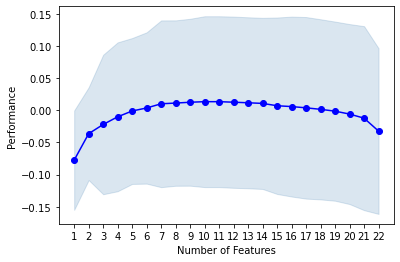

In [20]:
fig = plot_sfs(sfs1.get_metric_dict())

In [21]:
forward_feature_df = pd.DataFrame.from_dict(sfs2.get_metric_dict()).T.sort_values(by="avg_score",ascending=False).drop(["cv_scores"],axis=1)
forward_feature_df

,feature_idx,avg_score,feature_names,ci_bound,std_dev,std_err
11,"(0, 2, 3, 4, 6, 7, 8, 12, 13, 19, 21)",0.013362,"(const, % Silica Feed, Starch Flow, Amina Flow...",0.0985461,0.132684,0.044228
10,"(2, 3, 4, 6, 7, 8, 12, 13, 19, 21)",0.013362,"(% Silica Feed, Starch Flow, Amina Flow, Ore P...",0.0985461,0.132684,0.044228
12,"(0, 2, 3, 4, 6, 7, 8, 12, 13, 19, 20, 21)",0.012536,"(const, % Silica Feed, Starch Flow, Amina Flow...",0.0987468,0.132954,0.0443181
9,"(2, 4, 6, 7, 8, 12, 13, 19, 21)",0.0121911,"(% Silica Feed, Amina Flow, Ore Pulp pH, Ore P...",0.0975561,0.131351,0.0437837
13,"(0, 2, 3, 4, 6, 7, 8, 9, 12, 13, 19, 20, 21)",0.0116451,"(const, % Silica Feed, Starch Flow, Amina Flow...",0.0986218,0.132786,0.044262
8,"(2, 4, 6, 7, 8, 13, 19, 21)",0.0113146,"(% Silica Feed, Amina Flow, Ore Pulp pH, Ore P...",0.0982501,0.132285,0.0440951
14,"(0, 2, 3, 4, 6, 7, 8, 9, 12, 13, 18, 19, 20, 21)",0.0106762,"(const, % Silica Feed, Starch Flow, Amina Flow...",0.0987002,0.132891,0.0442971
7,"(2, 4, 6, 7, 8, 13, 19)",0.0100806,"(% Silica Feed, Amina Flow, Ore Pulp pH, Ore P...",0.0961848,0.129505,0.0431682
15,"(0, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 18, 19, 20...",0.00887526,"(const, % Silica Feed, Starch Flow, Amina Flow...",0.100044,0.134701,0.0449002
16,"(0, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 14, 18, 19...",0.00665475,"(const, % Silica Feed, Starch Flow, Amina Flow...",0.0990418,0.133351,0.0444505


選 Average $R^2$ 最高的變數組合作為 Forward stepwise regression 的結果

In [22]:
select_features['Forward Stepwise Regression'] = forward_feature_df.reset_index()['feature_names'][0]
select_features_df.loc['Forward Stepwise Regression'] = np.nan

for col in select_features['Forward Stepwise Regression']:
    select_features_df[col]['Forward Stepwise Regression'] = 1

select_features['Forward Stepwise Regression']

('const',
 '% Silica Feed',
 'Starch Flow',
 'Amina Flow',
 'Ore Pulp pH',
 'Ore Pulp Density',
 'Flotation Column 01 Air Flow',
 'Flotation Column 05 Air Flow',
 'Flotation Column 06 Air Flow',
 'Flotation Column 05 Level',
 'Flotation Column 07 Level')

---
## (c) (5%) Give a comparison between (a) and (b). The results are consistent?

下表為三種方法選到的自變數有哪些，標註為 1 表示此方法有選到此變數，若此方法沒有選到這變數則其對應的 cell 為空值。

In [23]:
select_features_df.dropna(axis='columns', how='all')

,const,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 05 Level,Flotation Column 07 Level
OLS,NaN,NaN,1,1,1,1,1,1,1,1,NaN,NaN,1,1
Backward Stepwise Regression,1,1,1,1,NaN,1,1,1,NaN,NaN,1,1,1,1
Forward Stepwise Regression,1,1,1,1,NaN,1,1,1,NaN,NaN,1,1,1,1


從上表可觀察到 Forward stepwise regression 與 backward stepwise regression 挑選出的變數剛好一樣，並且挑選出的變數與 OLS 中 p-value $\leq$ 0.05 的變數類似（不同的方法下在統計上顯著的變數）。

---
## (d) (5%) From a methodology aspect, what’s the difference between Ridge regression and Lasso? Why does Lasso support the variables selection rather than ridge? (hint: answer with description or formulation. No computation needed.)

Ridge regression 與 LASSO regression 的差異主要在 shrinkage method 的不同：
1. Ridge regression 的 shrinkage method 為 L2 regularization $(\lambda \sum^p_{j=1} \beta_j^2)$

$$\arg \min_{\beta} \sum^n_{i=1} \left( y_i - \beta_0 - \sum^p_{j=1} \beta_j x_{ij} \right)^2 + \lambda \sum^p_{j=1} \beta_j^2 。$$

2. LASSO regression 為 L1 regularization$(\lambda \sum^p_{j=1} \vert \beta_j \vert)$

$$\arg \min_{\beta} \sum^n_{i=1} \left( y_i - \beta_0 - \sum^p_{j=1} \beta_j x_{ij} \right)^2 + \lambda \sum^p_{j=1} \vert \beta_j \vert 。$$


由於 L1 norm 與 L2 norm 造成 ridge 與 LASSO regression 的限制式在圖形上的差異，絕對值的限制式為有稜角的菱形、而平方的限制式為圓形（如下圖所示）。菱形限制式與 $\beta$ 係數的可行解區域容易交集在 0，因此 LASSO regression 隨著懲罰項 $\lambda$ 的增加，$\beta$ 係數容易被壓為 0，當係數為 0 時可視為剔除此自變數。

![title](region.png)

---
## (e) (5%) What’s the benefit to use the Elastic Net? (hint: answer with description or formulation. No computation needed.)

Elastic-net regression (fixed $\alpha$) 可以視為將 LASSO regression 與 Ridge regression（L1 regularization 與 L2 regularization）以線性組合的方式合起來：

$$\arg \min_{\beta} \sum^n_{i=1} \left( y_i - \beta_0 - \sum^p_{j=1} \beta_j x_{ij} \right)^2 + \lambda \left( \alpha \sum^p_{j=1} \vert \beta_j \vert + \frac{1-\alpha}{2}\sum^p_{j=1} \beta_j^2 \right)$$

由此綜合 ridge 的優點（有效正規化優勢，預測效果較好）以及 LASSO 的優點（挑選變數，解決參數估計偏誤的問題）。

---
## (f) (5%) Identify the important variable by ridge regression.

參考助教的課程講義，用 cross validation 來驗證不同懲罰值下表現較好（RSS 加上懲罰項後最低）的模型。

In [24]:
from sklearn.linear_model import RidgeCV

In [25]:
X = fp_df.drop(columns=['% Silica Concentrate', '% Iron Concentrate'])
y = fp_df['% Silica Concentrate']

將自變數做標準化後再訓練，以利收斂

In [26]:
std = StandardScaler()
X_std = pd.DataFrame(std.fit_transform(X), columns = X.columns)

In [27]:
ridge_cv = RidgeCV(cv=10).fit(X_std, y)

In [28]:
select_features['Ridge Regression'] = X_std.columns[ridge_cv.coef_ != 0.]
select_features_df.loc['Ridge Regression'] = np.nan

for col in select_features['Ridge Regression']:
    select_features_df[col]['Ridge Regression'] = 1
    
select_features['Ridge Regression']

Index(['% Iron Feed', '% Silica Feed', 'Starch Flow', 'Amina Flow',
       'Ore Pulp Flow', 'Ore Pulp pH', 'Ore Pulp Density',
       'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
       'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow',
       'Flotation Column 07 Air Flow', 'Flotation Column 01 Level',
       'Flotation Column 02 Level', 'Flotation Column 03 Level',
       'Flotation Column 04 Level', 'Flotation Column 05 Level',
       'Flotation Column 06 Level', 'Flotation Column 07 Level'],
      dtype='object')

---
## (g) (5%) Identify the important variable by lasso.

參考助教的課程講義，用 cross validation 來驗證不同懲罰值下表現較好（RSS 加上懲罰項後最低）的模型。

In [29]:
from sklearn.linear_model import LassoCV

In [30]:
X = fp_df.drop(columns=['% Silica Concentrate', '% Iron Concentrate'])
y = fp_df['% Silica Concentrate']

將自變數做標準化後再訓練，以利收斂

In [31]:
std = StandardScaler()
X_std = pd.DataFrame(std.fit_transform(X), columns = X.columns)

In [32]:
lasso_cv = LassoCV(cv=10, random_state=0, max_iter=5000).fit(X, y)

In [33]:
select_features['LASSO Regression'] = X.columns[lasso_cv.coef_ != 0.]
select_features_df.loc['LASSO Regression'] = np.nan
for col in select_features['LASSO Regression']:
    select_features_df[col]['LASSO Regression'] = 1
    
select_features['LASSO Regression']

Index(['Starch Flow', 'Amina Flow', 'Flotation Column 01 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 03 Level',
       'Flotation Column 04 Level', 'Flotation Column 05 Level',
       'Flotation Column 07 Level'],
      dtype='object')

---
## (h) (5%) Identify the important variable by elastic net.

In [34]:
from sklearn.linear_model import ElasticNetCV

In [35]:
X = fp_df.drop(columns=['% Silica Concentrate', '% Iron Concentrate'])
y = fp_df['% Silica Concentrate']

設 l1 regularization 與 l2 regularization 各半，用 cross validation 來驗證不同懲罰值下表現較的模型。

In [36]:
elasticnet_cv = ElasticNetCV(cv=10, random_state=0).fit(X, y)

In [37]:
select_features['Elastic net'] = X.columns[elasticnet_cv.coef_ != 0.]
select_features_df.loc['Elastic net'] = np.nan
for col in select_features['Elastic net']:
    select_features_df[col]['Elastic net'] = 1
    
select_features['Elastic net']

Index(['Starch Flow', 'Amina Flow', 'Flotation Column 01 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 03 Level',
       'Flotation Column 04 Level', 'Flotation Column 05 Level',
       'Flotation Column 07 Level'],
      dtype='object')

---
## (i) (5%) Give a comparison between (f), (g) and (h). The results are consistent?

下表為六種方法選到的自變數有哪些，標註為 1 表示此方法有選到此變數，若此方法沒有選到這變數則其對應的 cell 為空值。

In [38]:
select_features_df.dropna(axis='columns', how='all')

,const,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level
OLS,NaN,NaN,NaN,1,1,1,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1
Backward Stepwise Regression,1,NaN,1,1,1,NaN,1,1,1,NaN,...,1,1,NaN,NaN,NaN,NaN,NaN,1,NaN,1
Forward Stepwise Regression,1,NaN,1,1,1,NaN,1,1,1,NaN,...,1,1,NaN,NaN,NaN,NaN,NaN,1,NaN,1
Ridge Regression,NaN,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
LASSO Regression,NaN,NaN,NaN,1,1,NaN,NaN,NaN,1,NaN,...,NaN,NaN,NaN,NaN,NaN,1,1,1,NaN,1
Elastic net,NaN,NaN,NaN,1,1,NaN,NaN,NaN,1,NaN,...,NaN,NaN,NaN,NaN,NaN,1,1,1,NaN,1


由於 Ridge regression 為 L2 regularization，其限制式導致與係數可行解區的交集不易落在 0 的點，因此若同樣以自變數係數不為 0 的方式來挑選變數較不合適，因為自變數的係數多為接近 0 但並非為 0，因此不會被剔除。

下表為不考慮 Ridge regression 挑選的變數，比較其他挑選方法所挑選出的變數有哪些。

In [39]:
select_features_df.drop(index='Ridge Regression').dropna(axis='columns', how='all')

,const,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 07 Level
OLS,NaN,NaN,1,1,1,1,1,1,1,1,NaN,NaN,NaN,NaN,1,1
Backward Stepwise Regression,1,1,1,1,NaN,1,1,1,NaN,NaN,1,1,NaN,NaN,1,1
Forward Stepwise Regression,1,1,1,1,NaN,1,1,1,NaN,NaN,1,1,NaN,NaN,1,1
LASSO Regression,NaN,NaN,1,1,NaN,NaN,NaN,1,1,NaN,NaN,NaN,1,1,1,1
Elastic net,NaN,NaN,1,1,NaN,NaN,NaN,1,1,NaN,NaN,NaN,1,1,1,1


從上表可觀察到 LASSO regression 與 Elastic net（L1 regularization 與 L2 regularization 各半）挑選到的變數（係數不為 0）剛好相同。

---
## (j) (5%) What is “adaptive elastic net”? Why we need it? How to build it? Please simply describe or formulate it. (No computation needed.)

根據 Hui Zou 與 Hao Helen Zhang 於 2009 年發布的論文中指出，adaptive elastic-net 可以視為 elastic-net 與 adaptive LASSO 的組合。論文中也證明 adaptive elastic-net 同時滿足 oracle property 並且成功解決 collinearity 問題.

以下為 adaptive elastic-net 的 formulation：
1. 首先計算 elastic-net 的係數並轉換為 adaptive elastic-net 中 L1 regularization 的權重：

$$ \hat{w_j} = \left( | \hat{\beta_j} \left(\rm | enet | \right) \right)^{-\gamma} $$

2. 再來解以下 optimization problem 找出最佳係數組合：

$$ arg \min_{\beta} \left( 1 + \frac{\lambda_2}{n} \right) \left( \sum^n_{i=1} \left( y_i - \beta_0 - \sum^p_{j=1} \beta_j x_{ij} \right)^2 + \lambda_1^* \sum^p_{j=1} \hat{w_j} \vert \beta_j \vert + \lambda_2 \sum^p_{j=1} \beta_j^2 \right) $$

---
## (k) (5%) Which columns are highly-correlated? Show the table of the coefficient estimation by using linear regression. Any multicollinearity problem?

根據老師上課指出（MDS_Lecture02），當變數之間具有高相關性（資訊重疊），迴歸模型的係數變異會變大，因為係數可以任意分配。其原因為如果有兩個高相關的自變數，在做高斯消去法時自變數矩陣 $X$ 可能就不會 full rank，可能不會 nonsingular 而無法算矩陣的 inverse，determinant 接近 0 有多重解。

以下印出自變數間的相關係數矩陣，以及 OLS 迴歸報表來檢視共線性問題。

In [40]:
corr = X.corr()
corr.style.background_gradient(cmap='coolwarm')

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level
% Iron Feed,1.000000,-0.971833,0.010829,-0.086668,0.173879,0.003863,-0.128495,-0.064857,-0.176825,-0.062733,-0.135588,0.114150,-0.045097,-0.008441,0.036455,0.018312,0.023975,0.009193,0.016861,-0.003251,0.019607
% Silica Feed,-0.971833,1.000000,0.004561,0.078412,-0.162403,0.011527,0.107540,0.094566,0.189771,0.085386,0.158653,-0.124311,0.070617,0.036668,-0.045239,-0.033085,-0.029596,-0.028883,-0.036286,-0.010980,-0.038512
Starch Flow,0.010829,0.004561,1.000000,0.263796,0.046497,0.257577,0.228972,0.174785,0.175662,0.165230,0.080268,-0.091961,0.205152,0.185778,-0.278442,-0.260817,-0.289952,-0.017631,-0.053268,-0.070104,-0.039103
Amina Flow,-0.086668,0.078412,0.263796,1.000000,0.222549,0.121703,0.653971,0.108524,0.121238,0.096544,0.011618,-0.043820,0.122964,0.080251,-0.267850,-0.220429,-0.283843,-0.185610,-0.200909,-0.193709,-0.157923
Ore Pulp Flow,0.173879,-0.162403,0.046497,0.222549,1.000000,0.120019,0.010047,-0.129178,-0.117603,-0.133875,-0.154917,0.175930,-0.154286,-0.131686,-0.008553,-0.004892,-0.055256,-0.019774,-0.001137,-0.035891,0.007132
Ore Pulp pH,0.003863,0.011527,0.257577,0.121703,0.120019,1.000000,0.115029,0.161973,0.144382,0.193584,0.146289,-0.141036,0.114097,0.166961,-0.165759,-0.146946,-0.138386,0.050431,0.019436,-0.071256,0.032675
Ore Pulp Density,-0.128495,0.107540,0.228972,0.653971,0.010047,0.115029,1.000000,-0.009968,0.027188,-0.038241,-0.102256,0.052165,-0.031511,-0.057859,-0.111719,-0.094298,-0.149500,-0.089430,-0.138090,-0.088751,-0.088420
Flotation Column 01 Air Flow,-0.064857,0.094566,0.174785,0.108524,-0.129178,0.161973,-0.009968,1.000000,0.849803,0.954937,0.474909,-0.202548,0.660401,0.643751,-0.438686,-0.418422,-0.361816,-0.059518,-0.073527,-0.101374,-0.108685
Flotation Column 02 Air Flow,-0.176825,0.189771,0.175662,0.121238,-0.117603,0.144382,0.027188,0.849803,1.000000,0.862121,0.430847,-0.177731,0.589866,0.580347,-0.435277,-0.414863,-0.362395,-0.072583,-0.098934,-0.104931,-0.116526
Flotation Column 03 Air Flow,-0.062733,0.085386,0.165230,0.096544,-0.133875,0.193584,-0.038241,0.954937,0.862121,1.000000,0.491893,-0.224506,0.660472,0.649034,-0.439448,-0.414186,-0.355313,-0.045144,-0.048649,-0.085378,-0.084468


抓出相關係數大於 0.8 的自變數 pair

In [41]:
high_corr_pair = (corr.abs().where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
                            .stack()
                            .sort_values(ascending=False))
high_corr_pair[high_corr_pair >= 0.8]

% Iron Feed                   % Silica Feed                   0.971833
Flotation Column 01 Air Flow  Flotation Column 03 Air Flow    0.954937
Flotation Column 02 Air Flow  Flotation Column 03 Air Flow    0.862121
Flotation Column 06 Air Flow  Flotation Column 07 Air Flow    0.857554
Flotation Column 01 Air Flow  Flotation Column 02 Air Flow    0.849803
dtype: float64

檢視迴歸報表也可發現，相關係數高的自變數 pair，其變異程度（std_err）相較於本身係數也較大。

In [42]:
print(ols_result.summary())

                             OLS Regression Results                             
Dep. Variable:     % Silica Concentrate   R-squared:                       0.149
Model:                              OLS   Adj. R-squared:                  0.145
Method:                   Least Squares   F-statistic:                     33.99
Date:                  Fri, 12 Nov 2021   Prob (F-statistic):          5.39e-126
Time:                          14:19:59   Log-Likelihood:                -5985.7
No. Observations:                  4097   AIC:                         1.202e+04
Df Residuals:                      4075   BIC:                         1.215e+04
Df Model:                            21                                         
Covariance Type:              nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

---
## (l) (5%) Is it possible to predict % Silica in Concentrate with using % Iron Concentrate column (as they are highly correlated)? Why? What’s the potential issue? How to address it?

由於題目說明主要目標是要預測製作完成的 ore concentrate 的純度，因此拿同樣是從實驗室製作完成的測量而出的 % Iron Concentrate 來去預測 % Silica in Concentrate 並沒有意義，也許在模型中放入此變數可以提高 $R^2$ 因為兩者高度相關，但並無法幫助我們改善前期的製程。

---
---
# 2. (40%) Principal Component Analysis (PCA)- Faulty Steel Plates

## Load data and preprocessing

In [43]:
col_list = pd.read_excel('MDS_Assignment2_Steelplates.xlsx', sheet_name='Var_Name', header=None)[0].tolist()
steelplates_df = pd.read_excel('MDS_Assignment2_Steelplates.xlsx', sheet_name='Faults', names=col_list)
steelplates_df

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
1,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
2,853,860,369370,369415,176,13,45,18996,99,126,...,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
3,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0
4,430,441,100250,100337,630,20,87,62357,64,127,...,0.8736,-0.2267,0.9874,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1935,249,277,325780,325796,273,54,22,35033,119,141,...,-0.4286,0.0026,0.7254,0,0,0,0,0,0,1
1936,144,175,340581,340598,287,44,24,34599,112,133,...,-0.4516,-0.0582,0.8173,0,0,0,0,0,0,1
1937,145,174,386779,386794,292,40,22,37572,120,140,...,-0.4828,0.0052,0.7079,0,0,0,0,0,0,1
1938,137,170,422497,422528,419,97,47,52715,117,140,...,-0.0606,-0.0171,0.9919,0,0,0,0,0,0,1


### 檢查欄位的資料型態

In [44]:
steelplates_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1940 entries, 0 to 1939
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              1940 non-null   int64  
 1   X_Maximum              1940 non-null   int64  
 2   Y_Minimum              1940 non-null   int64  
 3   Y_Maximum              1940 non-null   int64  
 4   Pixels_Areas           1940 non-null   int64  
 5   X_Perimeter            1940 non-null   int64  
 6   Y_Perimeter            1940 non-null   int64  
 7   Sum_of_Luminosity      1940 non-null   int64  
 8   Minimum_of_Luminosity  1940 non-null   int64  
 9   Maximum_of_Luminosity  1940 non-null   int64  
 10  Length_of_Conveyer     1940 non-null   int64  
 11  TypeOfSteel_A300       1940 non-null   int64  
 12  TypeOfSteel_A400       1940 non-null   int64  
 13  Steel_Plate_Thickness  1940 non-null   int64  
 14  Edges_Index            1940 non-null   float64
 15  Empt

### 視覺化各變數檢視分布狀況

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe003ef1940>,
      dtype=object)

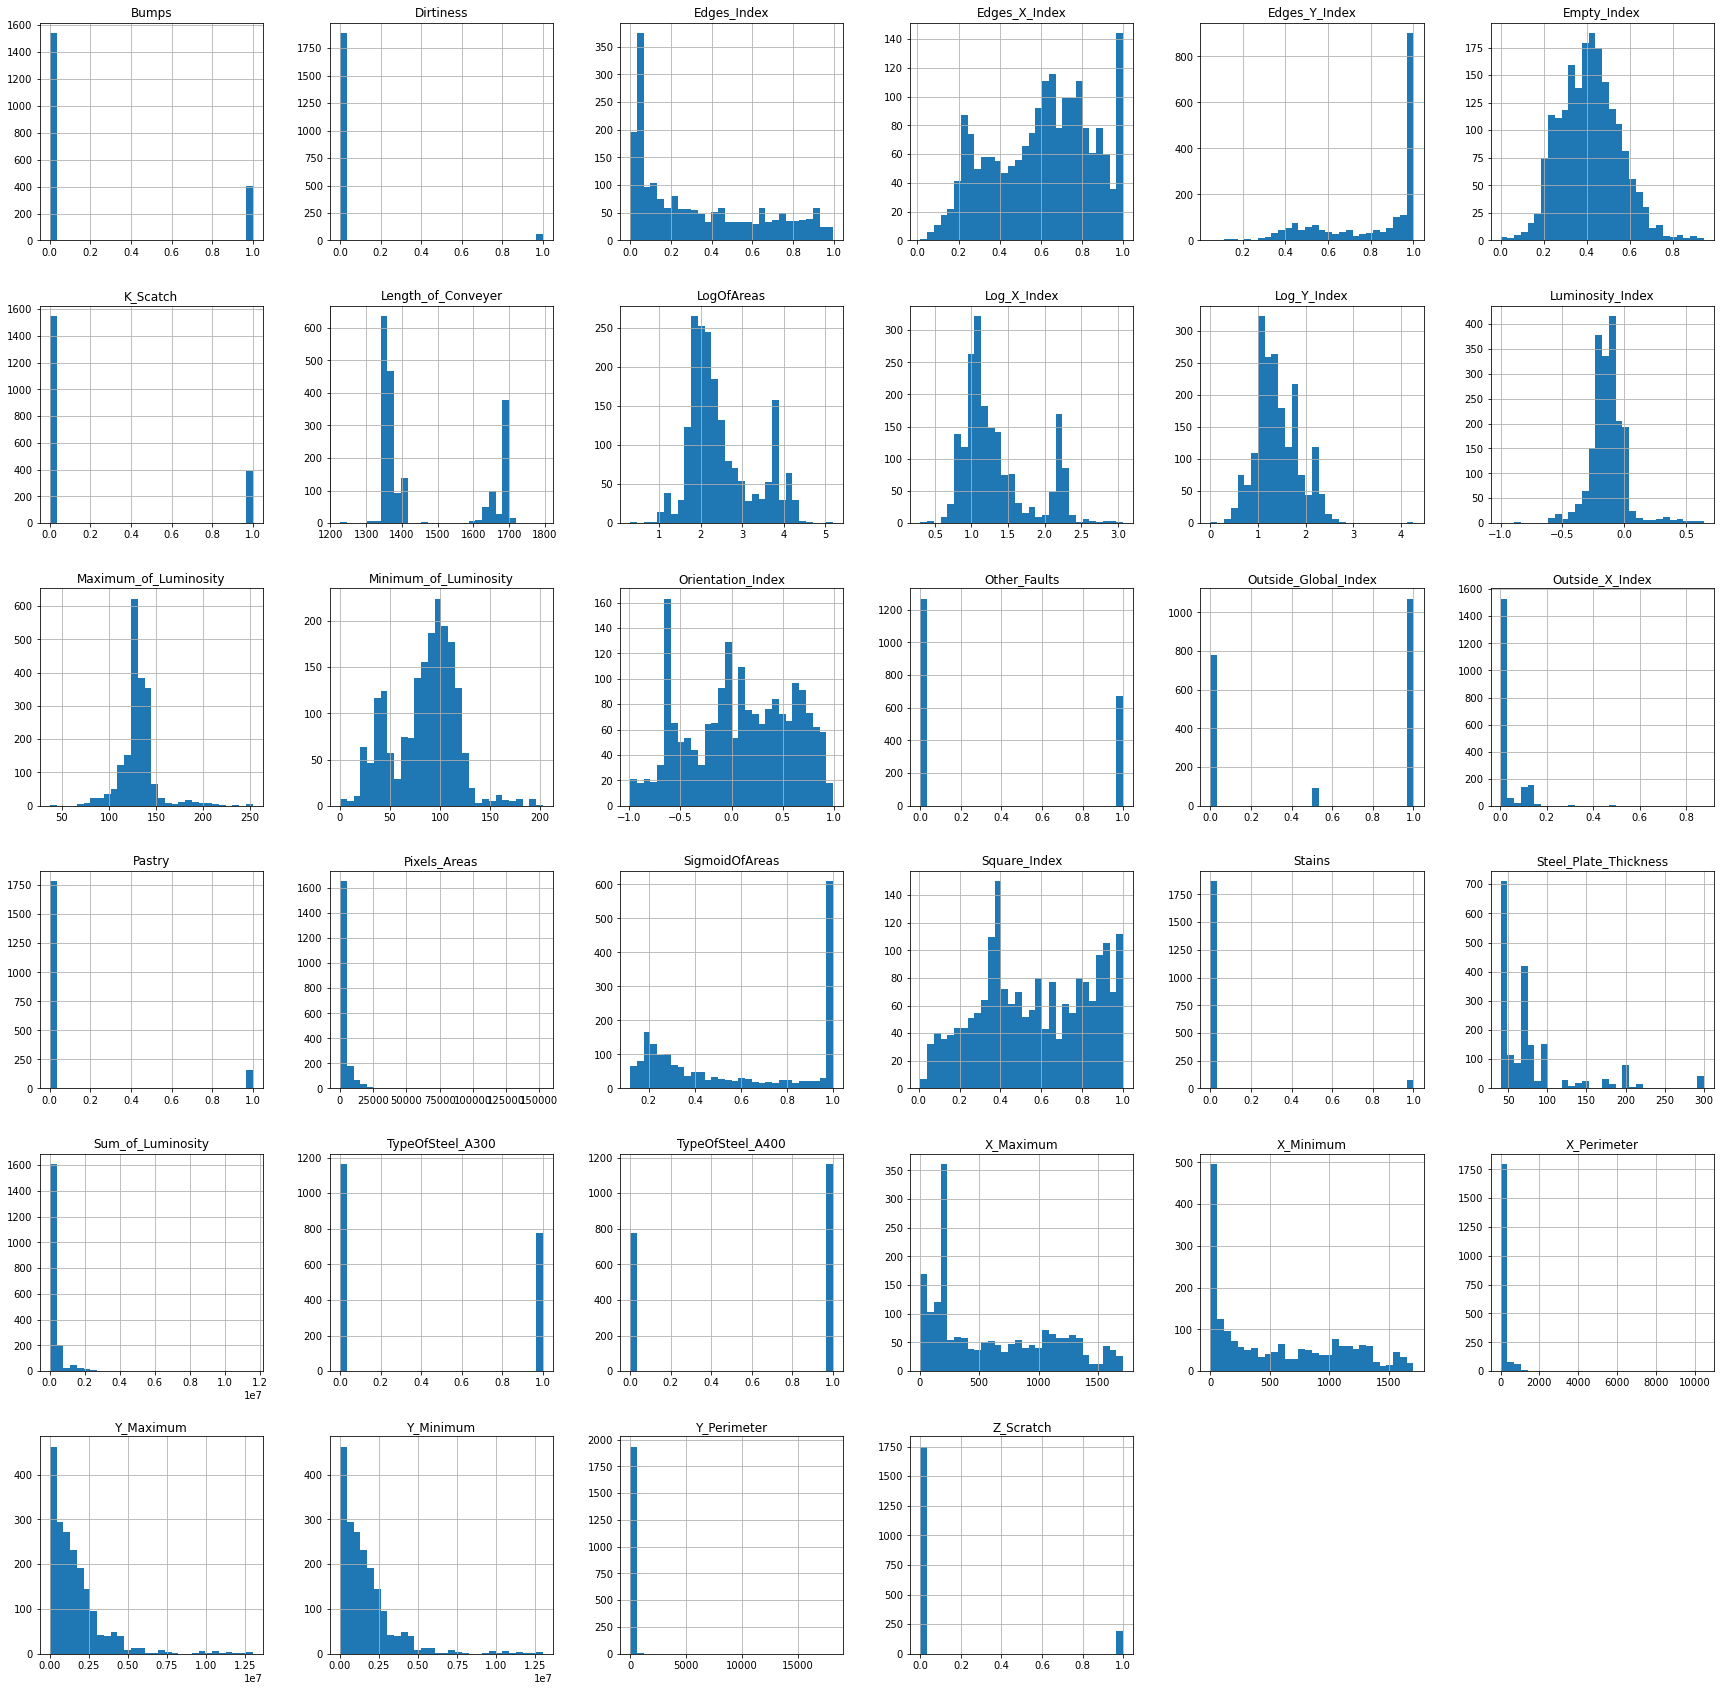

In [45]:
steelplates_df.hist(bins=30, figsize=(30, 30))

可以發現有一些自變數欄位（TypeOfSteel_A300、TypeOfSteel_A400）為 binary variable，而 Outside_Global_Index 則是只有 0、1、0.5 的類別變數，在接下來 PCA 分析會將其 drop 掉，不考慮這幾個欄位，

In [46]:
cat_cols = [col for col in steelplates_df if 
               steelplates_df[col].dropna().value_counts().index.isin([0,1]).all()]
cat_cols.append('Outside_Global_Index')

In [47]:
cat_cols

['TypeOfSteel_A300',
 'TypeOfSteel_A400',
 'Pastry',
 'Z_Scratch',
 'K_Scatch',
 'Stains',
 'Dirtiness',
 'Bumps',
 'Other_Faults',
 'Outside_Global_Index']

## “Randomly” split the dataset into training dataset and testing dataset

In [48]:
X = steelplates_df.drop(columns=['Pastry', 'Z_Scratch', 'Bumps', 'K_Scatch', 'Stains', 'Dirtiness', 'Other_Faults'])
X_nobool = steelplates_df.drop(columns=cat_cols)    # 使用沒有 binary 變數的自變數欄位們來進行預測（為與後面 PCA 的結果進行比較）
y = steelplates_df['Bumps']

X_train, X_test, y_train, y_test = train_test_split(X_nobool, y, test_size=0.2, random_state=42)

## (a) (10%) Use the Logistic Regression to predict the defect type “Bumps” in the testing dataset.That is, only consider the Bumps column in the 7 defect types. What’s the accuracy and confusion matrix?

In [49]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import plot_confusion_matrix

### 不做自變數的標準化進行訓練
使用 LogisticRegressionCV 來做 cross validation 與 tune hyperparameter。

Accuracy 0.8092783505154639


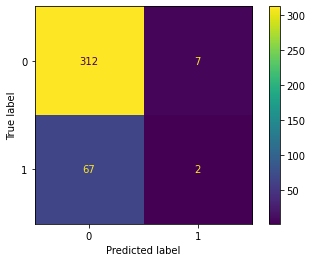

In [50]:
logistic_clf = LogisticRegressionCV(cv=10, random_state=0, scoring='accuracy').fit(X_train, y_train)
print('Accuracy', logistic_clf.score(X_test, y_test))
plot_confusion_matrix(logistic_clf, X_test, y_test)

### 將自變數做標準化後進行訓練

將 traing dataset 的標準化套用在 testing dataset

In [51]:
std = StandardScaler()
X_train_std = pd.DataFrame(std.fit_transform(X_train), columns = X_train.columns)
X_test_std = pd.DataFrame(std.transform(X_test), columns = X_test.columns)
X_train_std

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,1.586154,1.584816,-0.883466,-0.883480,-0.326732,-0.301707,-0.141680,-0.368669,-0.023298,-0.347195,...,-0.274087,-0.482135,-0.033652,0.792941,-0.500547,-0.794449,-0.333501,0.831048,-0.606787,-0.904309
1,-0.807713,-0.908866,-0.787728,-0.787746,-0.336212,-0.264441,-0.143794,-0.373753,1.256949,0.699217,...,0.833352,-0.382847,-0.216698,-0.481872,-0.788131,-0.330264,-0.721656,-0.577148,1.137187,-0.830615
2,-0.056128,-0.142357,0.105052,0.105021,-0.347179,-0.332762,-0.171280,-0.388948,0.819791,0.699217,...,0.833352,-0.510005,1.615414,0.792941,-1.644627,-1.328293,-1.773267,-0.577148,0.822711,-1.347364
3,-1.029905,-0.821901,0.626225,0.626226,0.785167,0.580254,0.135291,0.825982,-1.397223,-0.292121,...,-0.690115,1.648203,-0.121877,-1.592402,1.650904,1.891088,0.924641,-1.407380,-0.391440,1.220990
4,-1.016380,-0.890664,-0.877034,-0.877030,0.414720,0.207594,0.048605,0.426426,-1.147418,-0.181972,...,-0.749547,1.116925,0.532802,-1.575063,1.431994,1.645503,0.625094,-1.439769,-0.404429,1.220990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1547,-0.143072,-0.221233,-0.786818,-0.786832,-0.323387,-0.295496,-0.139565,-0.362555,0.101604,0.093399,...,0.017169,-0.433362,0.160526,0.792941,-0.426513,-0.612038,-0.281924,0.672324,-0.092004,-0.704535
1548,-1.093664,-1.216279,-0.728436,-0.728452,-0.324130,-0.314129,-0.143794,-0.364957,-0.273103,-0.292121,...,0.268927,-0.461232,1.615414,0.792941,-0.442214,-0.612038,-0.388165,0.535125,-0.402378,-0.801019
1549,0.082983,0.009326,0.321222,0.321201,-0.329521,-0.283074,-0.128994,-0.368053,0.663664,-0.181972,...,-0.889454,-0.471683,-0.936515,0.792941,-0.570879,-0.901343,-0.058200,1.166400,0.269644,-0.779414
1550,0.523501,0.472468,-0.932791,-0.932808,-0.331937,-0.304813,-0.154365,-0.375542,-0.085750,-1.558830,...,0.648779,-0.459490,0.143210,0.792941,-0.639935,-0.794449,-0.721656,0.328121,-1.033381,-1.102308


Accuracy 0.8530927835051546


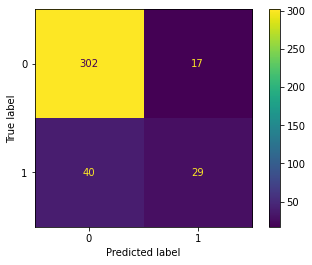

In [52]:
logistic_clf = LogisticRegressionCV(cv=10, random_state=0, scoring='accuracy').fit(X_train_std, y_train)
print('Accuracy', logistic_clf.score(X_test_std, y_test))
plot_confusion_matrix(logistic_clf, X_test_std, y_test)

---
## (b) (5%) For PCA, which variables should not be put into the PCA analysis (eg. binary variable).

除了二元變數外，類別變數、文字資料不宜放入 PCA 分析中。

---
## (c) (5%) What’s eigenvalues and eigenvectors of covariance matrix in PCA? How can you interpret from these eigenvalues?

PCA 的目標是找出多組變數的權重，使得每組變數線性組合後讓個體之間其變異量最大。以線性代數的 formulation 來看，第一個 principle component（PC）是希望 $\arg \max_a a^TB^TBa$, subject to $a^Ta=1$。$B^TB$ 就是變數的 correlation matrix。而 $a$ 則是對應於 $B^TB$ 的最大 eigenvalue 的 eigenvector：

$$a=e_1 \max \frac{a^TB^TBa}{a^Ta} = a^TB^TBa = \lambda_1$$

而如果是第二個 PC 的話則是得到次大的 variance（eigenvalue）與其對應到的 eigenvactor。

在第 $i$ 個 PC 中，eigenvalue（$\lambda_i$）為個體間的變異量，而 eigenvector（$e_i$）為線性組合的係數，可以知道 PC 和原變數之間的關係（例如：正影響/負影響；影響程度多大）。

### 主成份分析

In [53]:
from sklearn.decomposition import PCA

印出 10 個 PC 的 eigenvalue（變異量）與 eigenvector（係數組合）：

In [54]:
pc_count = 10
pca = PCA(n_components=pc_count)
X_train_transformed = pca.fit_transform(X_train_std)
cov_matrix = pca.get_covariance()
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_

X_test_transformed = pca.transform(X_test_std)

for eigenvalue, eigenvector in zip(eigenvalues, eigenvectors):
    print(eigenvalue, eigenvector)

7.981178645648276 [-0.18544676 -0.15004103  0.02387101  0.02390942  0.28929759  0.26669755
  0.18317097  0.30414223 -0.2295437   0.00978942 -0.09504239 -0.08385963
 -0.16149157  0.17168063 -0.05393652  0.27537217 -0.15867766 -0.25164985
  0.32647957  0.31221877  0.28291034 -0.07817348 -0.05536722  0.27594553]
2.9235574777603017 [-0.12534203 -0.10756107  0.03477668  0.03476536  0.03014224  0.02133731
 -0.0262939   0.04680967  0.23955416  0.38576398 -0.14598616 -0.2218648
  0.08783456  0.04483312  0.17998893  0.14929044  0.32196787 -0.24481198
 -0.07459128  0.13628351 -0.25701672 -0.42902841  0.41011897 -0.13732163]
2.352717373207509 [ 0.10401403  0.09196038 -0.34092836 -0.34082361  0.26522921  0.31269239
  0.37880854  0.21987278  0.20435305  0.2718775   0.05429916  0.14085031
  0.11176427  0.04917478  0.04382677 -0.10787814 -0.14396358  0.15016525
 -0.08629098 -0.16692301  0.05334294  0.23307959  0.27064641 -0.11149102]
2.2381818592763483 [ 0.28846459  0.30247452  0.41434931  0.41443155

做完 PCA 後縮減至 5 個維度

### 各主成份中原特徵值的線性組合係數

In [55]:
pc_columns = []
for i in range(pc_count):
    pc_name = 'PC' + str(i+1)
    pc_columns.append(pc_name)
    
factor_loading = pd.DataFrame(pca.components_.T, columns=pc_columns, index=X_train_std.columns)
factor_loading

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
X_Minimum,-0.185447,-0.125342,0.104014,0.288465,-0.049043,-0.510381,0.022584,-0.140439,0.183434,-0.048721
X_Maximum,-0.150041,-0.107561,0.091960,0.302475,-0.072893,-0.560829,0.017478,-0.129764,0.205194,-0.043341
Y_Minimum,0.023871,0.034777,-0.340928,0.414349,0.412828,0.050539,0.059075,0.076553,-0.136787,-0.070551
Y_Maximum,0.023909,0.034765,-0.340824,0.414432,0.412824,0.050592,0.059146,0.076576,-0.136773,-0.070534
Pixels_Areas,0.289298,0.030142,0.265229,0.239558,-0.069637,0.102151,0.023596,0.022972,0.026262,-0.000210
X_Perimeter,0.266698,0.021337,0.312692,0.263811,-0.041045,0.110430,0.117171,0.018510,0.000017,0.009666
Y_Perimeter,0.183171,-0.026294,0.378809,0.317550,-0.011237,0.183891,0.230597,0.068540,0.035491,0.045344
Sum_of_Luminosity,0.304142,0.046810,0.219873,0.187548,-0.070564,0.056569,-0.064375,-0.007625,0.004889,-0.027022
Minimum_of_Luminosity,-0.229544,0.239554,0.204353,-0.112162,0.271547,-0.053353,0.207518,-0.030151,-0.028068,-0.070069
Maximum_of_Luminosity,0.009789,0.385764,0.271877,-0.087613,0.276334,-0.145412,-0.268840,0.230740,0.012067,-0.098714


將 PCA 的結果另存成 dataframe

In [56]:
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns = pc_columns)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns = pc_columns)

X_train_transformed_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-2.344935,-1.607398,0.919453,0.762818,-1.287892,-0.993078,-1.152951,0.322732,1.055108,-0.293757
1,-0.758021,2.128699,0.778397,-1.663490,0.208579,0.704773,0.588647,-1.242623,-0.262925,-0.673678
2,-3.354935,2.314109,0.389775,0.921645,-0.252575,1.479000,-0.367653,-0.054358,0.391357,1.002144
3,4.439091,0.727864,-1.981813,-0.089065,-0.260703,-0.114450,0.141958,0.388361,0.462866,0.123059
4,3.350672,0.844385,-1.253920,-1.383197,-1.607511,0.041994,-0.262632,0.545509,1.140877,0.375434
...,...,...,...,...,...,...,...,...,...,...
1547,-1.521084,-0.051343,0.686993,-0.516388,-0.179014,0.923411,-0.668802,-0.554373,0.699616,1.434146
1548,-1.543988,-0.777190,0.198352,-0.870764,-1.812445,1.910145,-0.177952,2.087154,-1.052417,-1.364425
1549,-1.663932,-0.825121,0.693617,-0.087354,1.660709,0.333824,0.501549,-0.072735,-0.063933,1.617779
1550,-2.335925,-0.946077,0.112122,0.546093,-1.712215,1.140164,-0.896375,-1.055202,1.237714,1.591752


---
## (d) (5%) Plot a scree plot and decide the most appropriate number of principal components (PCs) to use.

### Scree plot

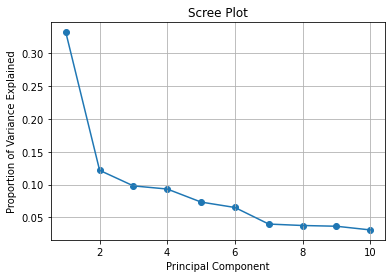

In [57]:
importance = pca.explained_variance_ratio_
plt.scatter(range(1, pc_count+1),importance)
plt.plot(range(1, pc_count+1),importance)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.grid()
plt.show()

由上圖 scree plot 可得知，從 1 到 2 個 PCs 可大幅下降變異量，而至 8 個以上的 PCs 後變異量下降幅度則不大，因此選擇 8 個 PCs。

---
## (e) (10%) Use the selected PCs and perform Logistic Regression to predict the defect type “Bumps” again. What’s the accuracy and confusion matrix?

根據上題，使用前 8 個 PC 來訓練新的 logistic regression 模型

In [58]:
X_train_transformed_df = X_train_transformed_df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8']]
X_test_transformed_df = X_test_transformed_df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8']]

使用 PCA 訓練集資料來進行訓練，並印出 PCA 測試集資料的 Accuracy 與 confusion matrix

Accuracy 0.8479381443298969


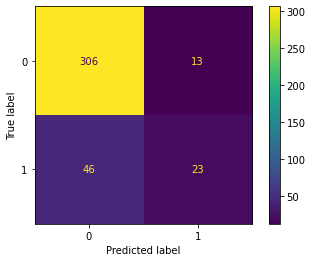

In [59]:
logistic_pca_clf = LogisticRegressionCV(cv=10, random_state=0, scoring='accuracy').fit(X_train_transformed_df, y_train)
print('Accuracy', logistic_pca_clf.score(X_test_transformed_df, y_test))
plot_confusion_matrix(logistic_pca_clf, X_test_transformed_df, y_test) 

---
## (f) (5%) What conclusions can you draw from above analysis? Give a comparison between (a) and (e). The results are consistent?

比較 (a) 跟 (e) 的預測結果可發現，首先在不做 feature selection 以及 dimension reduction 下，將資料做標準化後的預測結果較沒有做標準化的結果好，推測可能是標準化後的資料在訓練時較容易收斂。而做 PCA 取前 8 個 PC（變異量最大的前八個 component）來進行預測，Accuracy 接近且使用到更少的維度進行預測，可說是不錯的預測模型。